In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval

pd.set_option('display.max_columns', 500)

# Chargement des données

data = pd.read_csv("data.csv",sep=";",converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags_list_bis": literal_eval,
                                "Total":literal_eval})
data.set_index('Id', inplace=True)

# Partie 1 : Preprocessing

## Modèle non supervisé

In [2]:
from sklearn.model_selection import train_test_split

data_train , data_test = train_test_split(data,  test_size=0.1, random_state=42)

In [3]:
X = data['Total']
y = data['Tags_list_bis']

X_train = data_train['Total']
X_test = data_test['Total']
y_train = data_train['Tags_list_bis']
y_test = data_test['Tags_list_bis']

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

id2word = corpora.Dictionary(X)

texts = X  

corpus = [id2word.doc2bow(text) for text in texts] 

In [5]:
texts_test = X_test  

corpus_test = [id2word.doc2bow(text) for text in texts_test] 

## Modèle supervisé

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.8,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_train = multilabel_binarizer.transform(y_train)
y_test = multilabel_binarizer.transform(y_test)

# Partie 2 : Modèle non supervisé

## Test du Modèle LDA

In [8]:
full_lda_model = gensim.models.LdaModel(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20)

coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4620099473602074


In [9]:
# Création d'une fonction qui permet de voir les mots les plus communs dans chaque Topic

def plot_top_words_bis(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.get_topics()):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

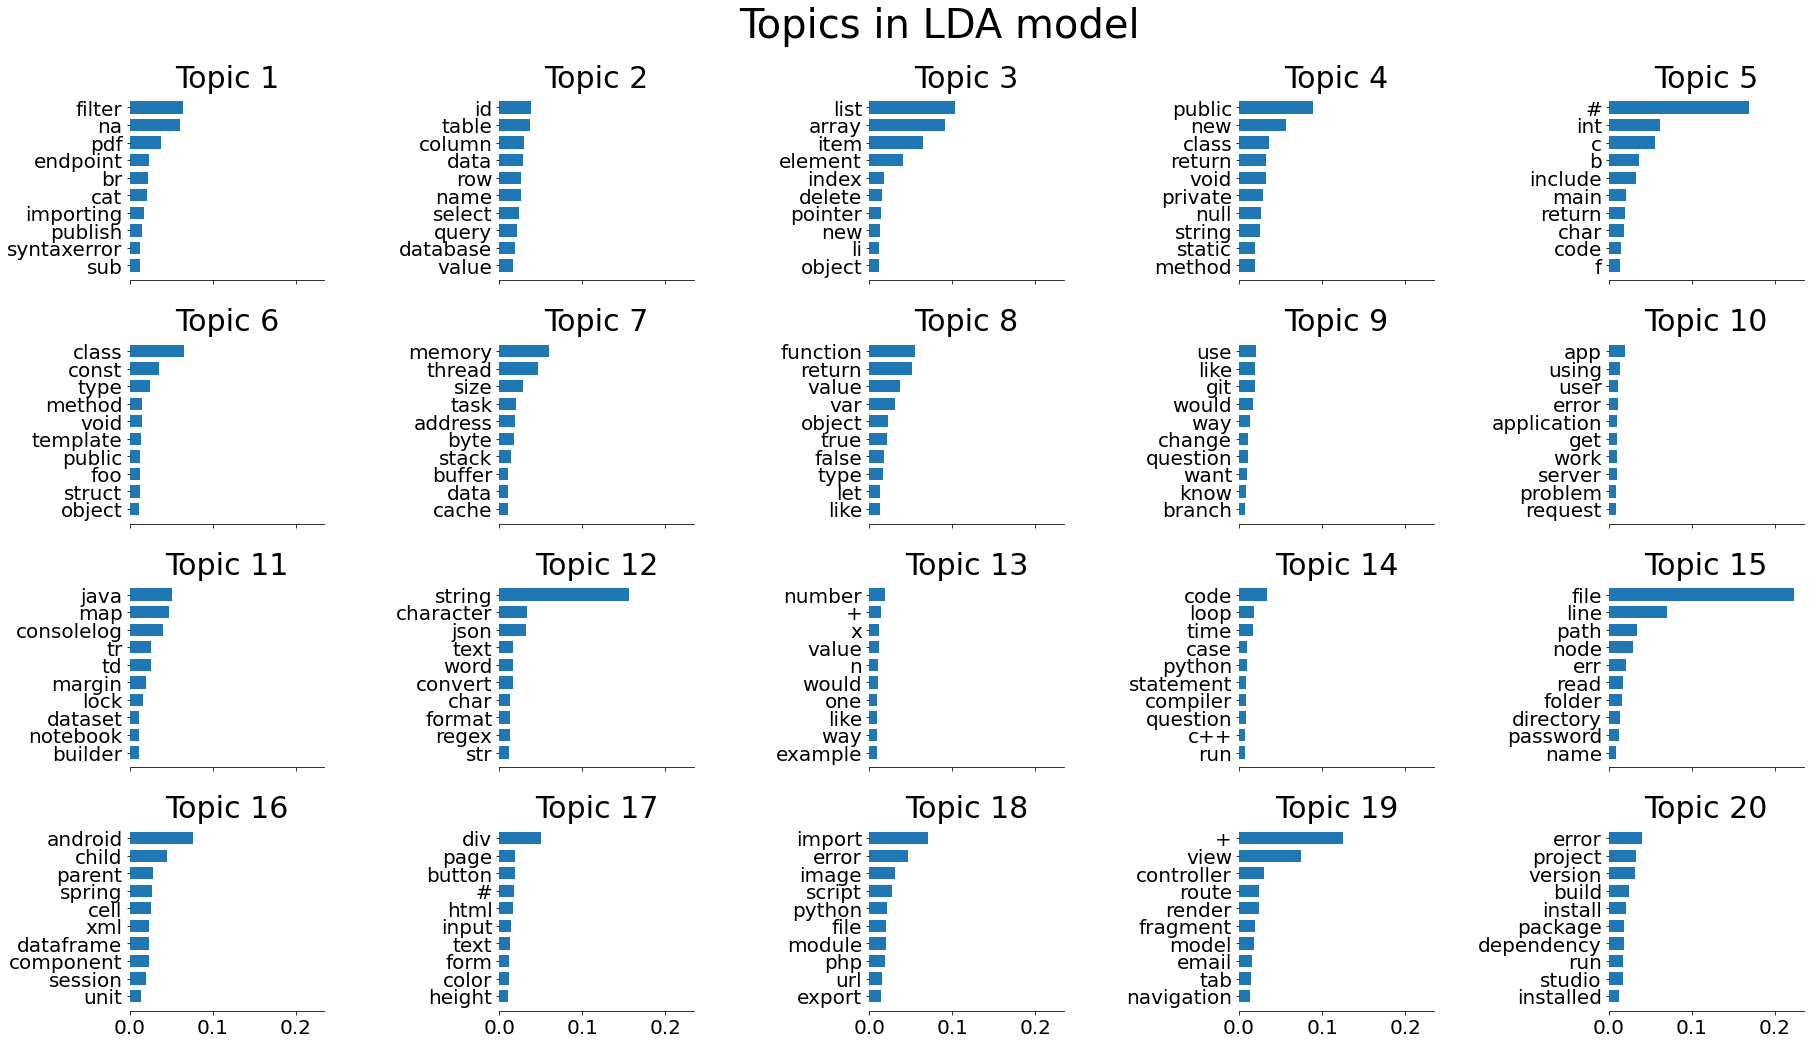

In [10]:
plot_top_words_bis(full_lda_model, id2word, 10, 'Topics in LDA model')

## Optimisation du nombre de Topics

In [11]:
coherence_test = []
for k in np.arange(1,61,10):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                      id2word=id2word,
                                      random_state=27,
                                      num_topics=k)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append((k, coherence_lda))

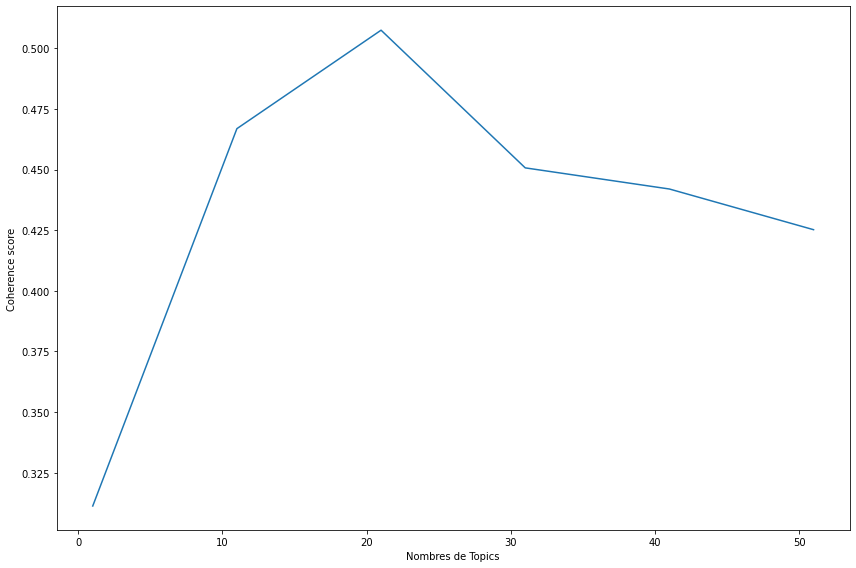

In [13]:
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence"])

fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]

ax1.plot(x, y1, label="Coherence score")

ax1.set_xlabel("Nombres de Topics")
ax1.set_ylabel("Coherence score")
fig.tight_layout()
plt.show()

In [14]:
coherence_test = []
for k in np.arange(16,24,1):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       random_state=27,
                                       num_topics=k)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append((k, coherence_lda))

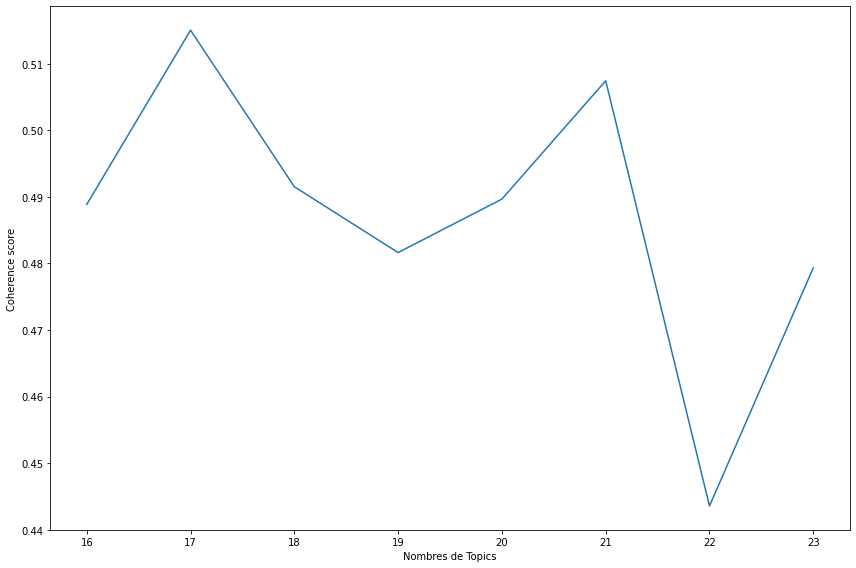

In [16]:
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence"])

fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]

ax1.plot(x, y1, label="Coherence score")

ax1.set_xlabel("Nombres de Topics")

ax1.set_ylabel("Coherence score")

fig.tight_layout()
plt.show()

In [25]:
lda_model_final = gensim.models.LdaModel(corpus=corpus,
                                         id2word=id2word,
                                         num_topics=17,
                                         random_state=27)

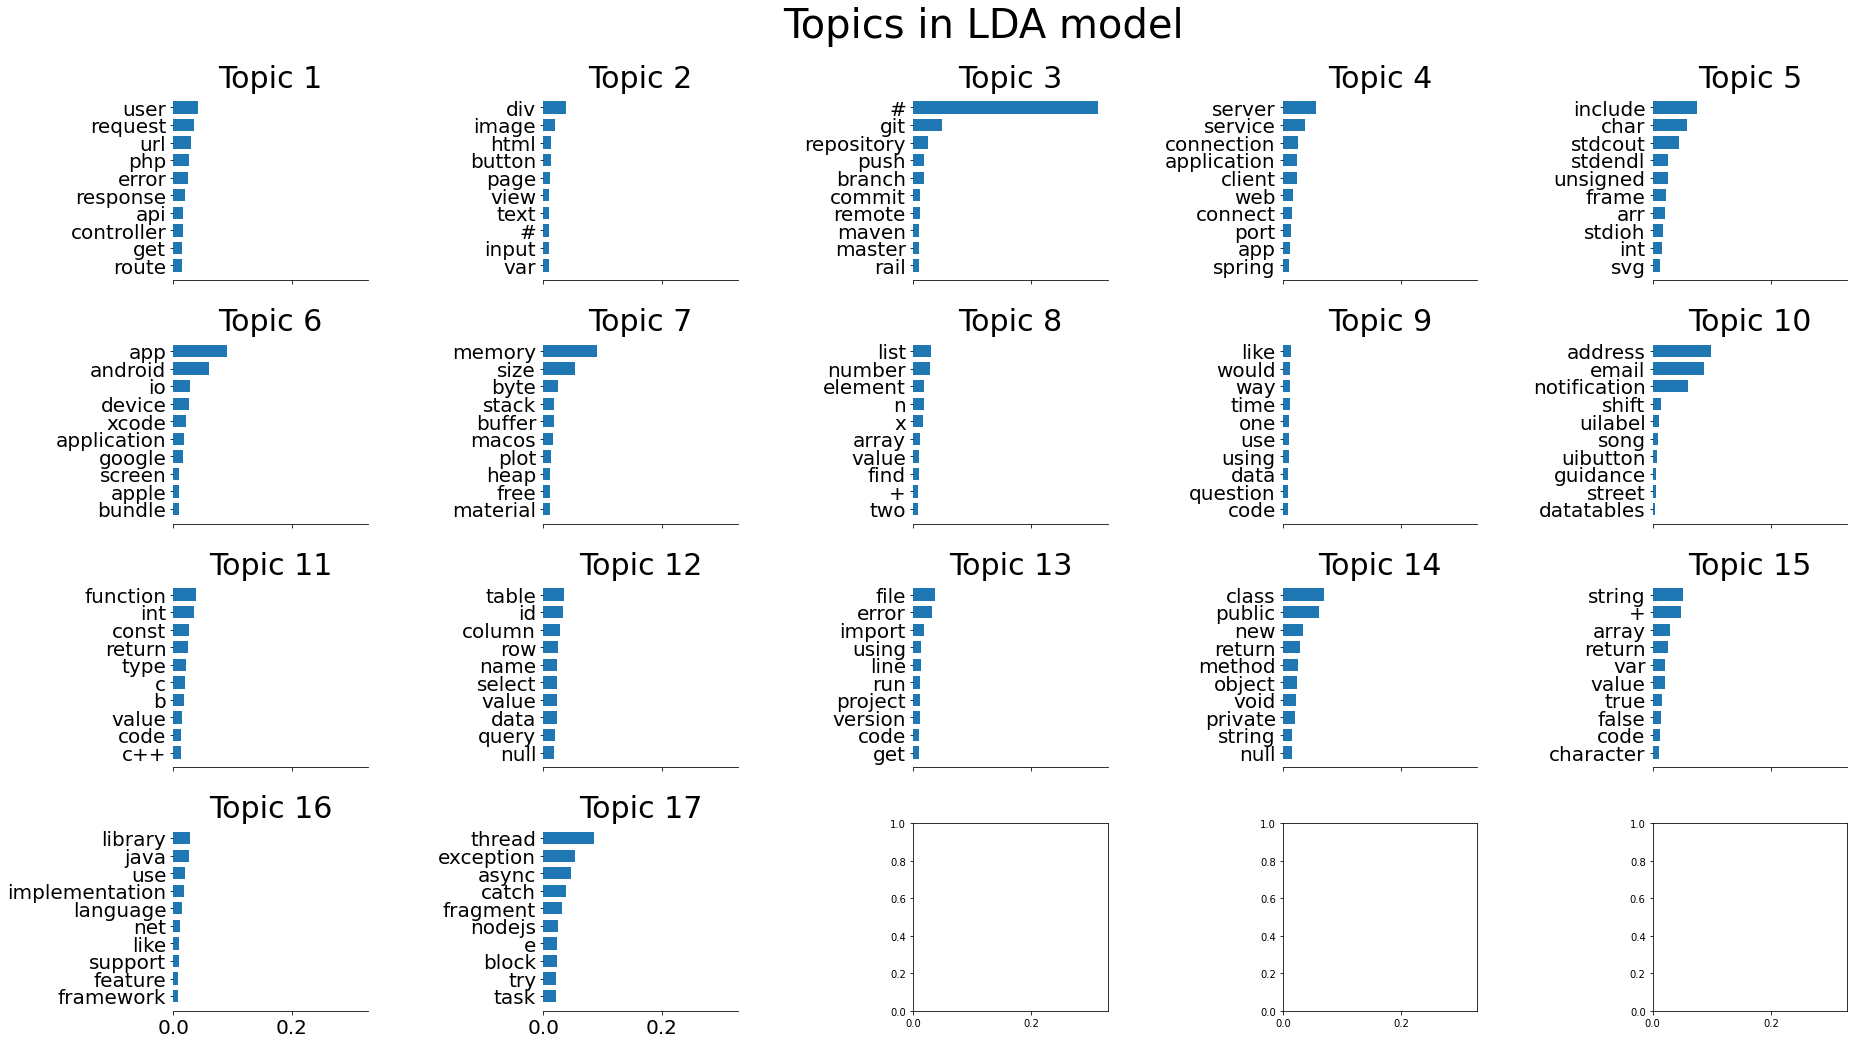

In [26]:
plot_top_words_bis(lda_model_final, id2word, 10, 'Topics in LDA model')

## Création du modèle de prédictions 

In [27]:
id2word_bis = [id2word[i] for i in range(0,len(id2word))]

In [28]:
def filter_tag(x, top_list):
    temp_list = []
    for item in x:
        if (item in top_list):
            temp_list.append(item)
    return temp_list

def count_split_tags(df, column):
    list_words = []
    for word in df[column]:
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

tags_list = count_split_tags(df=data, column='Tags_list_bis')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))
list_tag = tags_list.iloc[0:50].index

Le jeu de données compte 50 tags.


In [29]:
id2word_bis = filter_tag(id2word_bis,list_tag)

In [30]:
i = 0
feature_topic = {}

for topic_idx, topic in enumerate(lda_model_final.get_topics()):
        top_features_ind = topic.argsort()[:-150 - 1:-1]
        top_features = [id2word[i] for i in top_features_ind]
        top_features = filter_tag(top_features,list_tag)
        feature_topic[i] = top_features
        i = i + 1
        print(top_features)

['php', 'json']
['html', 'javascript', 'jquery']
['git', 'ruby']
['spring', 'mysql']
[]
['android', 'xcode', 'iphone']
['macos', 'linux', 'c++', 'r']
['list', 'algorithm', 'python', 'r', 'c']
['performance']
['c', 'list', 'string', 'python']
['c', 'c++']
['sql', 'mysql', 'list']
['python', 'r', 'c']
['string', 'java', 'list', 'spring']
['string', 'json', 'c', 'javascript', 'regex', 'list', 'python', 'java']
['java', 'c', 'c++', 'python', 'javascript']
[]


In [31]:
y = data["Tags_list_bis"]

In [32]:
doc_topic = pd.DataFrame(lda_model_final.get_document_topics(corpus,minimum_probability=0))

In [33]:
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

In [34]:
y_results = pd.DataFrame(y)
y_results['best_topic'] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags_list_bis"].apply(lambda x : len(x))

In [35]:
y_results["Body"] = data["Total"]

In [36]:
list_test = ['best_topic']
tag_predict = []
list_temp = []
list_temp2 = []

for i,j in zip(y_results['best_topic'],y_results['Body']):
        list_temp = feature_topic[i]
        for words1 in list_temp:
            for words2 in j:
                if words1 == words2 and words1 not in list_temp2 :
                    list_temp2.append(words1)
            
        tag_predict.append(list_temp2)
        list_temp2= []

In [37]:
y_results["Tags_predict"] = tag_predict

In [38]:
y_results

,Tags_list_bis,best_topic,nb_tags,Body,Tags_predict
Id,,,,,
13620,"[php, optimization, performance]",10,3,"[speed, difference, using, inline, string, v, ...",[]
39561,[visual-studio],1,1,"[visual, studio, keep, first, curly, brace, li...",[]
38288,[linux],12,1,"[add, user, ubuntu, specifically, command, run...",[]
40480,[java],8,1,"[java, passbyreference, passbyvalue, always, t...",[]
41400,"[c++, c]",10,2,"[wrap, function, variable, length, argument, l...",[c]
...,...,...,...,...,...
66507206,"[python, python-3.x]",12,2,"[quickly, get, last, line, huge, csv, file, li...",[]
66506475,"[c++, multithreading, c++11]",8,3,"[mutex, stdmutex, heavy, quite, often, site, f...",[]
66523786,"[ios, swift, xcode]",1,3,"[swiftui, putting, lazyvstack, lazyhstack, scr...",[]


## Performance

In [39]:
intersection1 = []
intersection2 = []
list_temp = []

for i,j in zip(y_results['Tags_list_bis'],y_results['Tags_predict']):
    for words1 in i:
            for words2 in j:
                if words1 == words2:
                    list_temp.append(words1)
    intersection1.append(list_temp)
    list_temp = []

In [40]:
y_results["Intersection_predict"] = intersection1

In [41]:
y_results['nombre_predict'] =[len(x) for x in y_results['Intersection_predict']]

In [42]:
list_accuracy = []

for i,j in zip(y_results['nb_tags'],y_results['nombre_predict']):
    if i == j:
        list_accuracy.append(1)
    else:
        list_accuracy.append(0)


In [43]:
y_results['Nb_tags_predict'] = list_accuracy

In [44]:
y_results

,Tags_list_bis,best_topic,nb_tags,Body,Tags_predict,Intersection_predict,nombre_predict,Nb_tags_predict
Id,,,,,,,,
13620,"[php, optimization, performance]",10,3,"[speed, difference, using, inline, string, v, ...",[],[],0,0
39561,[visual-studio],1,1,"[visual, studio, keep, first, curly, brace, li...",[],[],0,0
38288,[linux],12,1,"[add, user, ubuntu, specifically, command, run...",[],[],0,0
40480,[java],8,1,"[java, passbyreference, passbyvalue, always, t...",[],[],0,0
41400,"[c++, c]",10,2,"[wrap, function, variable, length, argument, l...",[c],[c],1,0
...,...,...,...,...,...,...,...,...
66507206,"[python, python-3.x]",12,2,"[quickly, get, last, line, huge, csv, file, li...",[],[],0,0
66506475,"[c++, multithreading, c++11]",8,3,"[mutex, stdmutex, heavy, quite, often, site, f...",[],[],0,0
66523786,"[ios, swift, xcode]",1,3,"[swiftui, putting, lazyvstack, lazyhstack, scr...",[],[],0,0


In [45]:
train_perf = multilabel_binarizer.transform(y_results['Tags_list_bis'])

In [46]:
train_perf_predict = multilabel_binarizer.transform(y_results['Tags_predict'])

In [47]:
import sklearn.metrics as metrics

In [48]:
print('\nF1 ',metrics.f1_score(train_perf, train_perf_predict, average='weighted'))


F1  0.24285299269502894


In [49]:
print('\nRecall ', metrics.recall_score(train_perf, train_perf_predict, average='weighted'))


Recall  0.1837350228000816


In [50]:
print('\nPrecision ',metrics.precision_score(train_perf, train_perf_predict, average='weighted'))


Precision  0.5144791516032484


C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print('\nAccuracy Faible: ', y_results['nombre_predict'].sum()/len(y_results))


Accuracy Faible:  0.27824445966031497


In [52]:
print('\nAccuracy Moyenne: ',(y_results['nombre_predict']/y_results['nb_tags']).sum()/len(y_results))


Accuracy Moyenne:  0.18997172074795277


In [53]:
print('\nAccuracy Forte: ',y_results['Nb_tags_predict'].sum()/len(y_results))


Accuracy Forte:  0.1342624292322851


In [54]:
Score = pd.DataFrame(index=["F1","Recall","Precision","Accuracy_moyenne","Accuracy_Faible","Accuracy_Forte"])

In [55]:
score = []
score.append(metrics.f1_score(train_perf, train_perf_predict, average='weighted'))
score.append(metrics.recall_score(train_perf, train_perf_predict, average='weighted'))
score.append(metrics.precision_score(train_perf, train_perf_predict, average='weighted'))
score.append((y_results['nombre_predict']/y_results['nb_tags']).sum()/len(y_results))
score.append(y_results['nombre_predict'].sum()/len(y_results))
score.append(y_results['Nb_tags_predict'].sum()/len(y_results))

Score['LDA'] = score

C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
Score

,LDA
F1,0.242853
Recall,0.183735
Precision,0.514479
Accuracy_moyenne,0.189972
Accuracy_Faible,0.278244
Accuracy_Forte,0.134262


In [57]:
doc_topic_test = pd.DataFrame(lda_model_final.get_document_topics(corpus_test,minimum_probability=0))

In [58]:
for topic in doc_topic_test.columns:
    doc_topic_test[topic] = doc_topic_test[topic].apply(lambda x : x[1])

In [59]:
y_results_test = pd.DataFrame(data_test["Tags_list_bis"])
y_results_test['best_topic'] = doc_topic_test.idxmax(axis=1).values
y_results_test["nb_tags"] = y_results_test["Tags_list_bis"].apply(lambda x : len(x))

In [60]:
y_results_test["Body"] = data_test["Total"]

In [61]:
list_test = ['best_topic']
tag_predict = []
list_temp = []
list_temp2 = []

for i,j in zip(y_results_test['best_topic'],y_results_test['Body']):
        list_temp = feature_topic[i]
        for words1 in list_temp:
            for words2 in j:
                if words1 == words2 and words1 not in list_temp2 :
                    list_temp2.append(words1)
            
        tag_predict.append(list_temp2)
        list_temp2= []

In [62]:
y_results_test["Tags_predict"] = tag_predict

In [63]:
intersection1 = []
intersection2 = []
list_temp = []

for i,j in zip(y_results_test['Tags_list_bis'],y_results_test['Tags_predict']):
    for words1 in i:
            for words2 in j:
                if words1 == words2:
                    list_temp.append(words1)
    intersection1.append(list_temp)
    list_temp = []

In [64]:
y_results_test["Intersection_predict"] = intersection1

In [65]:
y_results_test['nombre_predict'] =[len(x) for x in y_results_test['Intersection_predict']]

In [66]:
list_accuracy = []

for i,j in zip(y_results_test['nb_tags'],y_results_test['nombre_predict']):
    if i == j:
        list_accuracy.append(1)
    else:
        list_accuracy.append(0)


In [67]:
y_results_test['Nb_tags_predict'] = list_accuracy

In [68]:
y_results_test

,Tags_list_bis,best_topic,nb_tags,Body,Tags_predict,Intersection_predict,nombre_predict,Nb_tags_predict
Id,,,,,,,,
11419700,[git],12,1,"[git, gui, crash, every, time, open, repositor...",[],[],0,0
18305398,"[html, css]",1,2,"[zindex, stacking, removing, child, stacking, ...",[html],[html],1,0
18249672,[c++],8,1,"[always, use, booleans, opinion, one, bit, eve...",[],[],0,0
4796789,[c++],10,1,"[default, inheritance, access, specifier, exam...",[c++],[c++],1,1
36777619,[reactjs],10,1,"[state, seems, getting, overwritten, instead, ...",[],[],0,0
...,...,...,...,...,...,...,...,...
19874502,"[ios, objective-c]",10,2,"[nsinvocation, getreturnvalue, double, value, ...",[],[],0,0
37202716,"[c++, c++11]",10,2,"[is_const, work, expected, reference, wrote, t...",[],[],0,0
8407164,"[c++, optimization]",10,2,"[reference, variable, c++, assume, following, ...",[c++],[c++],1,0


In [69]:
test_perf = multilabel_binarizer.transform(y_results_test['Tags_list_bis'])

In [70]:
test_perf_predict = multilabel_binarizer.transform(y_results_test['Tags_predict'])

In [71]:
Score_test = pd.DataFrame(index=["F1","Recall","Precision","Accuracy_moyenne","Accuracy_Faible","Accuracy_Forte"])

In [72]:
score = []
score.append(metrics.f1_score(test_perf, test_perf_predict, average='weighted'))
score.append(metrics.recall_score(test_perf, test_perf_predict, average='weighted'))
score.append(metrics.precision_score(test_perf, test_perf_predict, average='weighted'))
score.append((y_results_test['nombre_predict']/y_results_test['nb_tags']).sum()/len(y_results_test))
score.append(y_results_test['nombre_predict'].sum()/len(y_results_test))
score.append(y_results_test['Nb_tags_predict'].sum()/len(y_results_test))

Score_test['LDA'] = score

C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
Score_test

,LDA
F1,0.243540
Recall,0.184855
Precision,0.516554
Accuracy_moyenne,0.189164
Accuracy_Faible,0.280478
Accuracy_Forte,0.132599


# Partie 3 : Modèle supervisé

In [74]:
def metrics_test(model, data, y_true, y_pred):
    
    temp_df = data
    
    score=[]
    
    score.append(metrics.f1_score(y_true, y_pred, average='weighted'))
    score.append(metrics.recall_score(y_true, y_pred, average='weighted'))
    score.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    
    accuracy_moyenne = 0
    accuracy_faible = 0
    accuracy_forte = 0
    accuracy = y_true*y_pred
    test = accuracy.sum(axis=1)
    test_bis = y_true.sum(axis=1)
    n = len(test)
    ratio = test/test_bis
    for i in range(0,n):
        if test[i] == test_bis[i]:
            accuracy_forte += 1
        if test[i] > 0:
            accuracy_faible += 1
    accuracy_moyenne = ratio.sum()/n
    accuracy_forte = accuracy_forte/n
    accuracy_faible = accuracy_faible/n
    
    score.append(accuracy_moyenne)
    score.append(accuracy_faible)
    score.append(accuracy_forte)
    
    temp_df[model] = score
    
    return temp_df
    

In [75]:
def metrics_train(score, y_true, y_pred):
    
    accuracy_moyenne = 0
    accuracy_faible = 0
    accuracy_forte = 0
    accuracy = y_true*y_pred
    test = accuracy.sum(axis=1)
    test_bis = y_true.sum(axis=1)
    n = len(test)
    ratio = test/test_bis
    for i in range(0,n):
        if test[i] == test_bis[i]:
            accuracy_forte += 1
        if test[i] > 0:
            accuracy_faible += 1
    accuracy_moyenne = ratio.sum()/n
    accuracy_forte = accuracy_forte/n
    accuracy_faible = accuracy_faible/n
    
    score.append(accuracy_moyenne)
    score.append(accuracy_faible)
    score.append(accuracy_forte)
    
    return score

## LogiticRegression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier


param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1","l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)

grid_result = multi_logit_cv.fit(X_train[0:10000], y_train[0:10000])


print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.5848934614449545
Best Params:  {'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

param_logit_test = {"estimator__C": [10],
               "estimator__penalty": ["l1"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit_test,
                              n_jobs=-1,
                              cv=5,
                              scoring=("f1_weighted","precision_weighted","recall_weighted"),
                              refit="f1_weighted",
                              return_train_score = True)

grid_result = multi_logit_cv.fit(X_train, y_train)

Estimator_logit = multi_logit_cv.best_estimator_

logit_results = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best F1: ', np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
print('Best Precision: ', np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
print('Best Recall', np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))

Best F1:  [0.64604766]
Best Precision:  [0.75743337]
Best Recall [0.56989936]


In [79]:
score = []
score.append(np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
score.append(np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))
score.append(np.array(logit_results[logit_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
metrics_train(score, y_train, multi_logit_cv.predict(X_train))
Score['Logistic'] = score
Score

,LDA,Logistic
F1,0.242853,[0.64604766156991]
Recall,0.183735,[0.5698993590697314]
Precision,0.514479,[0.7574333671958158]
Accuracy_moyenne,0.189972,0.658652
Accuracy_Faible,0.278244,0.769952
Accuracy_Forte,0.134262,0.548663


In [80]:
Score_test = metrics_test('Logistic', Score_test , y_test, multi_logit_cv.predict(X_test))
Score_test

,LDA,Logistic
F1,0.243540,0.645631
Recall,0.184855,0.566892
Precision,0.516554,0.762950
Accuracy_moyenne,0.189164,0.610034
Accuracy_Faible,0.280478,0.726035
Accuracy_Forte,0.132599,0.497829


## RandomForestClassifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

param_rfc = {"estimator__n_estimators": [50, 100],
             "estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__min_samples_split":[2, 4, 8],
             "estimator__class_weight": ['balanced']}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True)

grid_result = multi_rfc_cv.fit(X_train[0:10000], y_train[0:10000])

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.5959293551095309
Best Params:  {'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}


In [83]:
param_rfc_test = {"estimator__n_estimators":[100],
                 "estimator__max_depth": [25],
                 "estimator__min_samples_leaf": [10],
                 "estimator__min_samples_split":[4],
                 "estimator__class_weight": ['balanced']}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc_test,
                            n_jobs=-1,
                            cv=5,
                            scoring=("f1_weighted","precision_weighted","recall_weighted"),
                            return_train_score = True,
                            refit="f1_weighted")

grid_result = multi_rfc_cv.fit(X_train, y_train)

rfc_results = pd.DataFrame.from_dict(grid_result.cv_results_)

Estimator_rfc = multi_rfc_cv.best_estimator_

print('Best F1: ', np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
print('Best Precision: ', np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
print('Best Recall', np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))

Best F1:  [0.64604516]
Best Precision:  [0.561304]
Best Recall [0.7919741]


In [85]:
score = []
score.append(np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
score.append(np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))
score.append(np.array(rfc_results[rfc_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
metrics_train(score, y_train, multi_rfc_cv.predict(X_train))
Score['RandomForrest'] = score
Score

,LDA,Logistic,RandomForrest
F1,0.242853,[0.64604766156991],[0.6460451608963717]
Recall,0.183735,[0.5698993590697314],[0.7919740964560849]
Precision,0.514479,[0.7574333671958158],[0.561303998702607]
Accuracy_moyenne,0.189972,0.658652,0.897368
Accuracy_Faible,0.278244,0.769952,0.925878
Accuracy_Forte,0.134262,0.548663,0.865395


In [86]:
Score_test = metrics_test('RandomForrest',Score_test, y_test, multi_rfc_cv.predict(X_test))
Score_test

,LDA,Logistic,RandomForrest
F1,0.243540,0.645631,0.643256
Recall,0.184855,0.566892,0.798525
Precision,0.516554,0.762950,0.554744
Accuracy_moyenne,0.189164,0.610034,0.813656
Accuracy_Faible,0.280478,0.726035,0.876169
Accuracy_Forte,0.132599,0.497829,0.745157


## MLPClassifier

In [46]:
from sklearn.neural_network import MLPClassifier

param_mlp = {
    'hidden_layer_sizes': [(100,20),(50,10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05, 0.1],
    'learning_rate_init': [0.001, 0.001, 0.01],
    'max_iter': [1000,1250,1500]
}

multi_mlp_cv = GridSearchCV(MLPClassifier(),
                            param_grid=param_mlp,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            random_state=42)

grid_result = multi_mlp_cv.fit(X_train[0:10000], y_train[0:10000])

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.5615590592930018
Best Params:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 20), 'learning_rate_init': 0.001, 'max_iter': 1250, 'solver': 'adam'}


In [89]:
param_mlp_test = {
    'hidden_layer_sizes': [(100, 20)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.1],
    'learning_rate_init': [0.001],
    'max_iter': [1250]
}

multi_mlp_cv = GridSearchCV(MLPClassifier(),
                            param_grid=param_mlp_test,
                            n_jobs=-1,
                            cv=5,
                            scoring=("f1_weighted","precision_weighted","recall_weighted"),
                            return_train_score = True,
                            refit="f1_weighted")

grid_result = multi_mlp_cv.fit(X_train, y_train)

mlp_results = pd.DataFrame.from_dict(grid_result.cv_results_)

Estimator_mlp = multi_mlp_cv.best_estimator_

print('Best F1: ', np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
print('Best Precision: ', np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
print('Best Recall', np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))

Best F1:  [0.64051492]
Best Precision:  [0.73554374]
Best Recall [0.58299172]


In [90]:
score = []
score.append(np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_f1_weighted']))
score.append(np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_recall_weighted']))
score.append(np.array(mlp_results[mlp_results.rank_test_f1_weighted==1]['mean_test_precision_weighted']))
metrics_train(score, y_train, multi_mlp_cv.predict(X_train))
Score['MLP'] = score
Score

,LDA,Logistic,RandomForrest,MLP
F1,0.242853,[0.64604766156991],[0.6460451608963717],[0.6405149185151362]
Recall,0.183735,[0.5698993590697314],[0.7919740964560849],[0.5829917200546425]
Precision,0.514479,[0.7574333671958158],[0.561303998702607],[0.7355437422178224]
Accuracy_moyenne,0.189972,0.658652,0.897368,0.726794
Accuracy_Faible,0.278244,0.769952,0.925878,0.846347
Accuracy_Forte,0.134262,0.548663,0.865395,0.604266


In [92]:
Score_test = metrics_test('MLP',Score_test, y_test, multi_mlp_cv.predict(X_test))
Score_test

C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA,Logistic,RandomForrest,MLP
F1,0.243540,0.645631,0.643256,0.643271
Recall,0.184855,0.566892,0.798525,0.577899
Precision,0.516554,0.762950,0.554744,0.759067
Accuracy_moyenne,0.189164,0.610034,0.813656,0.621828
Accuracy_Faible,0.280478,0.726035,0.876169,0.744572
Accuracy_Forte,0.132599,0.497829,0.745157,0.504092


# Partie 4 : Sélection du modèle final

<AxesSubplot:>

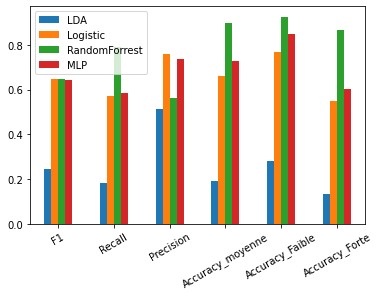

In [139]:
Score.plot(kind="bar", rot=30)

<AxesSubplot:>

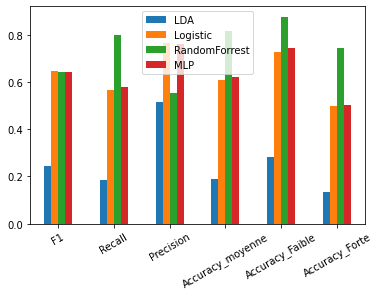

In [120]:
Score_test.plot(kind="bar", rot=30)

In [140]:
class Question_Predicteur:
    def __init__(self, TfidfVectorizer, MultiLabelBinarizer, Question_predicteur):
        self.TfidfVectorizer = TfidfVectorizer
        self.MultiLabelBinarizer = MultiLabelBinarizer
        self.Question_predicteur = Question_predicteur

    def predicte_Question(
        self,
        Question
    ):
        x  = BeautifulSoup(Question,"lxml").get_text()
        x = x.encode("ascii", "ignore").decode()
        x = re.sub("\'\w+", '', x)
        x = re.sub('[^\\w\\s#]', '', x)
        x = re.sub(r'http*\S+', '', x)
        x = re.sub(r'\w*\d+\w*', '', x)
        x = re.sub('\s+', ' ', x)
        x = x.lower()
        
        x = nltk.tokenize.word_tokenize(x)
        
        x = [word for word in x if word not in stop_words]
        
        x = wn.lemmatize(x)
              
        X_tfidf = self.TfidfVectorizer.transform(x)
        
        Tags_predict = self.Question_predicteur.predict(X_tfidf)
        
        Tags_predict = self.MultiLabelBinarizer.inverse_transform(Tags_predict)

        return Tags_predict

In [141]:
# On sauvegarde les différents estimateur

import pickle

Estimator = {
    "Tf-idf" : vectorizer,
    "Multi-Label-Binarizer" : multilabel_binarizer,
    "LogisticRegression": Estimator_logit,
    "RandomForrestClassifier" : Estimator_rfc,
    "MLPClassifier" : Estimator_mlp
}
pickle.dump(Estimator, open("save.p", "wb"))